# Example for creating family of Lyapunov via Natural Parameter Continuation

Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

In [3]:
param_earth_moon = r3bp.get_cr3bp_param('399','301')   # NAIF ID's '399': Earth, '301': Moon
lp = r3bp.lagrangePoints(param_earth_moon.mu)
param_earth_moon.mu

0.012150584269940354

In [9]:
# initial lyapunov member
lyapinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=1, lstar=param_earth_moon.lstar, az_km=0, family=1, phase=0.0)

gammaL: 0.15093428336575854, c2:5.147594489040959, c3:3.2468421844693967, c4: 3.58472967812957
Ax = 5939.17 [km], Ay = 21300.82 [km], Az = 0.00 [km]
Analytical period = 2.74183310 (non-dim)


In [10]:
lyapinit["period_guess"], lyapinit["state_guess"]

(2.7418330965142927,
 array([0.82380198, 0.        , 0.        , 0.        , 0.12482546,
        0.        ]))

In [11]:
p_conv, state_conv, flag_conv = r3bp.ssdc_periodic_xzplane(param_earth_moon.mu, lyapinit["state_guess"], 
                                                           lyapinit["period_guess"], fix="z", message=False)

In [13]:
flag_conv

1

In [14]:
prop0 = prop.propagate_cr3bp(param_earth_moon.mu, state_conv, p_conv)

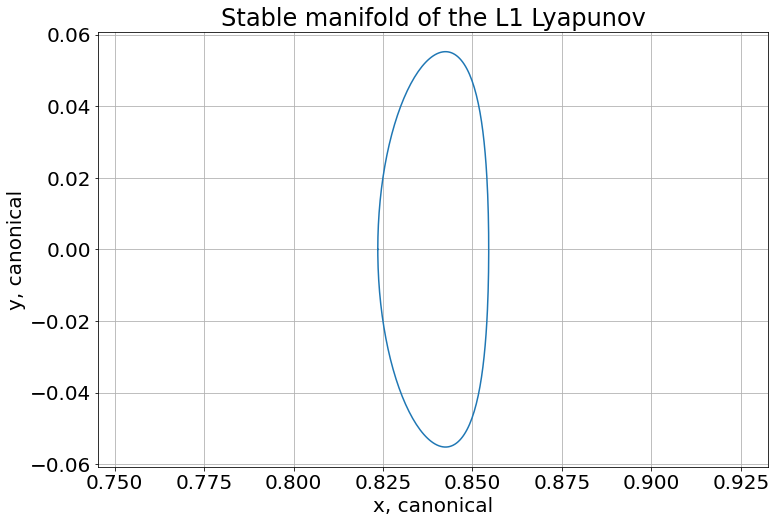

In [17]:
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(prop0["xs"], prop0["ys"])
ax.set(xlabel='x, canonical', ylabel='y, canonical', title='Stable manifold of the L1 Lyapunov')
plt.grid(True)
plt.axis("equal")
plt.show()

In [85]:
# initial member
lyapinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=1, lstar=param_earth_moon.lstar, az_km=0, family=1, phase=0.0)

period0 = lyapinit["period_guess"]
state0 = lyapinit["state_guess"]
print(f'Initial period0: {period0}')

# initialize list and append initial member
proplst = []
#proplst.append( prop.propagate_cr3bp(param_earth_moon.mu, state0, period0) )

# setup array of periods to use
step_period = 0.01
stop_period = 6.0

# step_period = -0.01
# stop_period = 2.0

periods = np.arange(period0, stop_period, step_period)

len(periods), stop_period

gammaL: 0.15093428336575854, c2:5.147594489040959, c3:3.2468421844693967, c4: 3.58472967812957
Ax = 5939.17 [km], Ay = 21300.82 [km], Az = 0.00 [km]
Analytical period = 2.74183310 (non-dim)
Initial period0: 2.7418330965142927


(326, 6.0)

In [86]:
# initialize pandas dataframe
df_keys = ["System", "Family", "mu", "Period", "Jacobi", "Stability", 
           "state_x", "state_y", "state_z", "state_vx", "state_vy", "state_vz",]
famdf = pd.DataFrame( columns=df_keys )
solcount = 0   # number of solutions

# run single shooting
state_iter = state0
p_iter     = period0
for period in tqdm(periods):
    p_iter, state_iter, conv_iter = r3bp.ssdc_periodic_xzplane(param_earth_moon.mu, state_iter, period, 
                                                               fix="period", message=False)
    if conv_iter==1:
        # store propagation output for plotting
        proptmp = prop.propagate_cr3bp(param_earth_moon.mu, state_iter, p_iter, stm_option=True)
        proplst.append( proptmp )
        monodromy = np.reshape( proptmp["stms"][:,-1] , (6,6) )
        # store solution into dataframe
        snew = pd.Series(["Earth_Moon",
                          "l1_lyapunov",
                          param_earth_moon.mu,
                          p_iter,
                          r3bp.jacobiConstant(param_earth_moon.mu, state_iter),
                          r3bp.stabilityIndex(monodromy), 
                          state_iter[0], state_iter[1], state_iter[2], 
                          state_iter[3], state_iter[4], state_iter[5] ], index=df_keys, name=int(solcount))
        famdf = pd.DataFrame.append(famdf, snew)
        solcount += 1
    else:
        print(f'Breaking at {period}!')
        break

In [87]:
famdf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Earth_Moon,l1_lyapunov,0.012151,2.741833,3.174654,1183.827544,0.823521,0.0,0.0,0.0,0.124977,0.0
1,Earth_Moon,l1_lyapunov,0.012151,2.751833,3.172070,1156.243816,0.822462,0.0,0.0,0.0,0.136064,0.0
2,Earth_Moon,l1_lyapunov,0.012151,2.761833,3.169529,1129.572358,0.821516,0.0,0.0,0.0,0.146115,0.0
3,Earth_Moon,l1_lyapunov,0.012151,2.771833,3.167031,1103.776033,0.820658,0.0,0.0,0.0,0.155339,0.0
4,Earth_Moon,l1_lyapunov,0.012151,2.781833,3.164575,1078.819448,0.819871,0.0,0.0,0.0,0.163885,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
321,Earth_Moon,l1_lyapunov,0.012151,5.951833,2.936873,59.421424,0.692860,0.0,0.0,0.0,0.654163,0.0
322,Earth_Moon,l1_lyapunov,0.012151,5.961833,2.936485,58.751308,0.692206,0.0,0.0,0.0,0.655616,0.0
323,Earth_Moon,l1_lyapunov,0.012151,5.971833,2.936095,58.579863,0.691547,0.0,0.0,0.0,0.657079,0.0
324,Earth_Moon,l1_lyapunov,0.012151,5.981833,2.935705,58.411302,0.690885,0.0,0.0,0.0,0.658550,0.0


In [88]:
# generate in other direction
# initial member
lyapinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=1, lstar=param_earth_moon.lstar, az_km=0, family=1, phase=0.0)

period0 = lyapinit["period_guess"]
state0 = lyapinit["state_guess"]
print(f'Initial period0: {period0}')

# setup array of periods to use
step_period = -0.01
stop_period = 2.0

periods = np.arange(period0, stop_period, step_period)

len(periods), stop_period

gammaL: 0.15093428336575854, c2:5.147594489040959, c3:3.2468421844693967, c4: 3.58472967812957
Ax = 5939.17 [km], Ay = 21300.82 [km], Az = 0.00 [km]
Analytical period = 2.74183310 (non-dim)
Initial period0: 2.7418330965142927


(75, 2.0)

In [89]:
# run single shooting
state_iter = state0
p_iter     = period0
double_avoid = 1
for period in tqdm(periods):
    p_iter, state_iter, conv_iter = r3bp.ssdc_periodic_xzplane(param_earth_moon.mu, state_iter, period, 
                                                               fix="period", message=False)
    if conv_iter==1:
        # store propagation output for plotting
        proptmp = prop.propagate_cr3bp(param_earth_moon.mu, state_iter, p_iter, stm_option=True)
        proplst.append( proptmp )
        monodromy = np.reshape( proptmp["stms"][:,-1] , (6,6) )
        # store solution into dataframe
        snew = pd.Series(["Earth_Moon",
                          "l1_lyapunov",
                          param_earth_moon.mu,
                          p_iter,
                          r3bp.jacobiConstant(param_earth_moon.mu, state_iter),
                          r3bp.stabilityIndex(monodromy), 
                          state_iter[0], state_iter[1], state_iter[2], 
                          state_iter[3], state_iter[4], state_iter[5] ], index=df_keys, name=int(solcount))
        if double_avoid==1:
            double_avoid=0
        else:
            famdf = pd.DataFrame.append(famdf, snew)
            solcount += 1
    else:
        print(f'Breaking at {period}!')
        break

Breaking at 2.691833096514294!



In [93]:
# re-order the dataframe
famdf.sort_values("state_x").reset_index()

,index,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,325,Earth_Moon,l1_lyapunov,0.012151,5.991833,2.935313,58.245620,0.690220,0.0,0.0,0.0,0.660032,0.0
1,324,Earth_Moon,l1_lyapunov,0.012151,5.981833,2.935705,58.411302,0.690885,0.0,0.0,0.0,0.658550,0.0
2,323,Earth_Moon,l1_lyapunov,0.012151,5.971833,2.936095,58.579863,0.691547,0.0,0.0,0.0,0.657079,0.0
3,322,Earth_Moon,l1_lyapunov,0.012151,5.961833,2.936485,58.751308,0.692206,0.0,0.0,0.0,0.655616,0.0
4,321,Earth_Moon,l1_lyapunov,0.012151,5.951833,2.936873,59.421424,0.692860,0.0,0.0,0.0,0.654163,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0,Earth_Moon,l1_lyapunov,0.012151,2.741833,3.174654,1183.827544,0.823521,0.0,0.0,0.0,0.124977,0.0
326,326,Earth_Moon,l1_lyapunov,0.012151,2.731833,3.177283,1212.362513,0.824730,0.0,0.0,0.0,0.112531,0.0
327,327,Earth_Moon,l1_lyapunov,0.012151,2.721833,3.179958,1241.889635,0.826154,0.0,0.0,0.0,0.098189,0.0
328,328,Earth_Moon,l1_lyapunov,0.012151,2.711833,3.182680,1272.451868,0.827916,0.0,0.0,0.0,0.080910,0.0


### Plot result

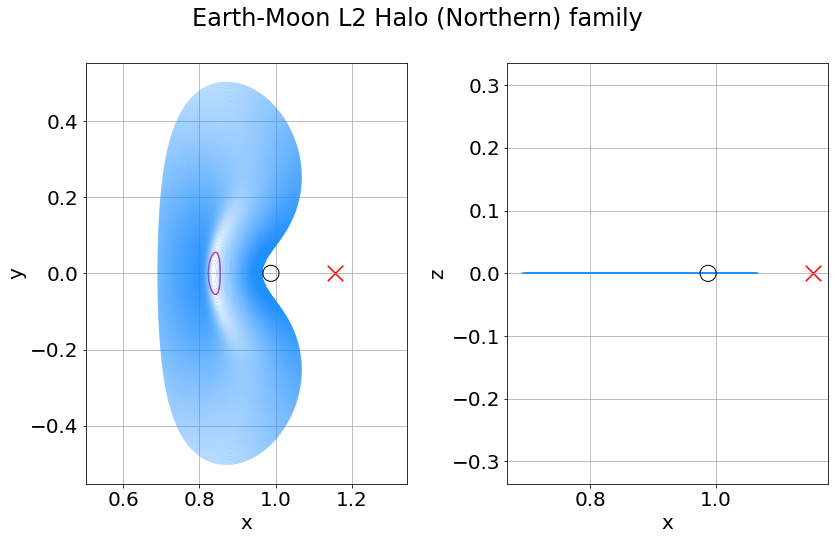

In [91]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].plot(prop0["xs"], prop0["ys"], c='deeppink')

for propout in tqdm(proplst):
    axs[0].plot(propout["xs"], propout["ys"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout["xs"], propout["zs"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

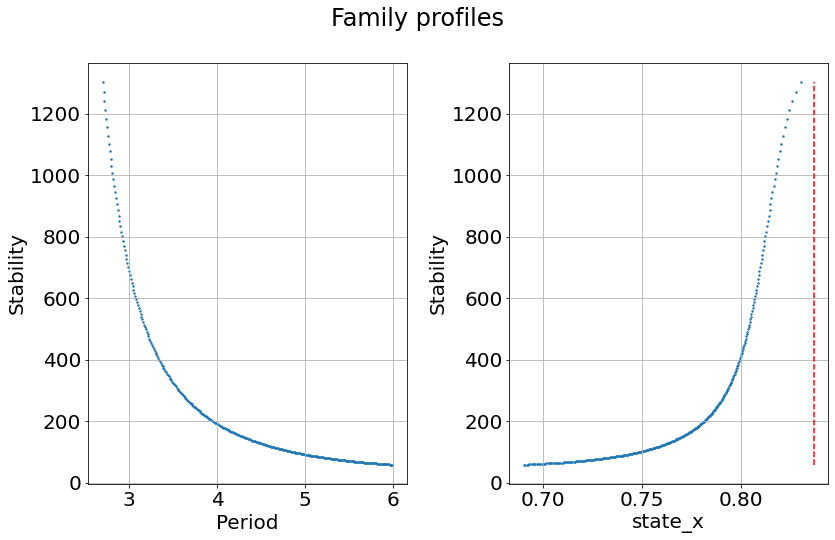

In [92]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].scatter(famdf["Period"], famdf["Stability"], s=2)
axs[0].set(xlabel="Period", ylabel="Stability")
axs[0].grid(True)

axs[1].scatter(famdf["state_x"], famdf["Stability"], s=2)
axs[1].set(xlabel="state_x", ylabel="Stability")
axs[1].vlines(lp.l1[0], min(famdf["Stability"]), max(famdf["Stability"]), color='r', linestyle='--')
axs[1].grid(True)

plt.suptitle('Family profiles')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Save resulting family into JSON file

In [ ]:
raise SystemExit("Stop before saving!")

In [96]:
savedf = famdf.sort_values("state_x").reset_index().drop(columns="index")
savedf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Earth_Moon,l1_lyapunov,0.012151,5.991833,2.935313,58.245620,0.690220,0.0,0.0,0.0,0.660032,0.0
1,Earth_Moon,l1_lyapunov,0.012151,5.981833,2.935705,58.411302,0.690885,0.0,0.0,0.0,0.658550,0.0
2,Earth_Moon,l1_lyapunov,0.012151,5.971833,2.936095,58.579863,0.691547,0.0,0.0,0.0,0.657079,0.0
3,Earth_Moon,l1_lyapunov,0.012151,5.961833,2.936485,58.751308,0.692206,0.0,0.0,0.0,0.655616,0.0
4,Earth_Moon,l1_lyapunov,0.012151,5.951833,2.936873,59.421424,0.692860,0.0,0.0,0.0,0.654163,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
325,Earth_Moon,l1_lyapunov,0.012151,2.741833,3.174654,1183.827544,0.823521,0.0,0.0,0.0,0.124977,0.0
326,Earth_Moon,l1_lyapunov,0.012151,2.731833,3.177283,1212.362513,0.824730,0.0,0.0,0.0,0.112531,0.0
327,Earth_Moon,l1_lyapunov,0.012151,2.721833,3.179958,1241.889635,0.826154,0.0,0.0,0.0,0.098189,0.0
328,Earth_Moon,l1_lyapunov,0.012151,2.711833,3.182680,1272.451868,0.827916,0.0,0.0,0.0,0.080910,0.0


In [98]:
# save output
flename = "l1_lyapunov.json"
pathjson = '../data/r3bp/Earth_Moon/' + flename
savedf.to_json(pathjson, orient='index', indent=4, double_precision=15)

print(f'Done! Saved at {pathjson}')

Done! Saved at ../data/r3bp/Earth_Moon/l1_lyapunov.json
